In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
# TODO: Add denoising criterion; Representation spartsity

In [2]:
# Defining the dataset
class _dataset(Dataset): #
    def __init__(self, variant, category, random_seed=42, tensor=True):
        """ 
        variant -> 'VLQ_HG', 'VLQ_SEM_HG', 'bkg', 'FCNC'
        category -> 'train, validation', 'test', 'all'
        tensor -> if true will return the data as a tensor, if False will return as a DataFrame
        """
        # TODO: Improve efficiency/handle names
        
        # Sanity checks
        assert variant in {'VLQ_HG', 'VLQ_SEM_HG', 'bkg', 'FCNC'}, "Invalid variant!"
        assert category in {'train', 'validation', 'test', 'all'}, "Invalid category!"

        # With specified variant, get data
        file = join(processed_data_path, variant + ".csv")
        data = pd.read_csv(file, index_col=0)

        # Shuffle the dataframe
        data = data.sample(frac=1, random_state=random_seed).reset_index(drop=True)

        # This will equally devide the dataset into 
        # train, validation and test
        train, validation, test = np.split(data.sample(frac=1), [int(len(data)*(1/3)), int(len(data)*(2/3))])
        
        if category == "train":
            data = train
        elif category == "validation":
            data = validation
        elif category == "test":
            data = test
        elif category == "all":
            del train, validation, test
            self.data = data
        
        # This data we want on a seperate variable
        if category != "all":
            # Weights
            if tensor:
                self.weights = torch.from_numpy(data["weights"].to_numpy(dtype=np.float32))
            else:
                self.weights = data["weights"]
            # Name
            self.name = data["name"]

            data.drop(["name", "weights"], axis=1, inplace=True)
            # Data
            if tensor:
                self.data = torch.from_numpy(data.to_numpy(dtype=np.float32))
            else:
                self.data = data
            self.n_samples = data.shape[0]


    def __getitem__(self, index):
        return self.data[index], self.weights[index]

    def __len__(self):
        return self.n_samples

    def all_data(self):
        return self.data

In [3]:
class VAE(pl.LightningModule):
    def __init__(self, dataset, batch_size, hidden_size, alpha, lr):
        """
        Args:
        - > variant e {'VLQ_HG', 'VLQ_SEM_HG', 'bkg', 'FCNC'}; it's the type of data
        - > hidden_size : Latent Hidden Size
        - > alpha : Hyperparameter to control the importance of
        reconstruction loss vs KL-Divergence Loss
        - > lr : Learning Rate, will not be used if auto_lr_find is used.
        - > dataset : Dataset to used
        """
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.hparams.batch_size = batch_size
        self.hidden_size = hidden_size
        self.lr = lr
        self.alpha = alpha

        # Architecture
        self.encoder = nn.Sequential(
            nn.Linear(69, 128), 
            nn.LeakyReLU(), 
            nn.Linear(128, 128),
            nn.LeakyReLU(), 
            nn.Linear(128, hidden_size),
            nn.LeakyReLU()
        )

        self.hidden2mu = nn.Linear(hidden_size, hidden_size)
        self.hidden2log_var = nn.Linear(hidden_size, hidden_size)
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 128), 
            nn.LeakyReLU(), 
            nn.Linear(128, 128),
            nn.LeakyReLU(), 
            nn.Linear(128, 69), 
            nn.LeakyReLU(),
        )

    def encode(self, x):
        # Pass through encoder
        out = self.encoder(x)
        mu = self.hidden2mu(out)
        log_var = self.hidden2log_var(out)
        return mu, log_var

    def decode(self, x):
        # Pass through encoder
        return self.decoder(x)

    def reparametrize(self, mu, log_var):
        # Reparametrization Trick
        # It outputs a sample of the dist.
        # mu -> average | log_var -> std
        
        log_var = torch.exp(0.5*log_var)
        z = torch.randn(size=(mu.size(0), mu.size(1))) # log_var, normal distribution
        z = z.type_as(mu)
        return mu + log_var*z

    def forward(self, x):
        # Pass through encoder
        mu, log_var = self.encode(x)
        # Reparametrization Trick
        hidden = self.reparametrize(mu, log_var)
        # Pass through decoder
        output = self.decoder(hidden)

        return mu, log_var, output, hidden

    def training_step(self, batch, batch_idx):
        x, weights = batch
        # Pass
        mu, log_var, x_out, _ = self.forward(x)

        # Losses
        kl_loss = (-0.5*(1+log_var - mu**2 -
                         torch.exp(log_var)).sum(dim=1)).mean(dim=0)

        recon_loss_criterion = nn.MSELoss()
        recon_loss = recon_loss_criterion(x, x_out)

        loss = recon_loss*self.alpha + kl_loss

        # Weights on final loss
        loss = (weights * loss) / weights.sum()
        loss = torch.mean(loss, dtype=torch.float32)

        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, weights = batch

        mu, log_var, x_out, _ = self.forward(x)

        # K-L Loss
        #kl_loss = (-0.5*(1+torch.log(log_var**2)-log_var**2 - mu**2).sum(dim=1)).mean(dim=0) 
        kl_loss = (-0.5*(1+log_var - mu**2 -
                         torch.exp(log_var)).sum(dim=1)).mean(dim=0)
        # Weights on KL Loss
        kl_loss = (weights * kl_loss) / weights.sum()
        kl_loss = torch.mean(kl_loss, dtype=torch.float32)

        # Reconstruction loss
        recon_loss_criterion = nn.MSELoss()
        recon_loss = recon_loss_criterion(x, x_out)
        # Weights on recon loss
        recon_loss = (weights * recon_loss) / weights.sum()
        recon_loss = torch.mean(recon_loss, dtype=torch.float32)


        loss = recon_loss*self.alpha + kl_loss

        self.log('val_kl_loss', kl_loss, on_step=False, on_epoch=True)
        self.log('val_recon_loss', recon_loss, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)

        return x_out, loss

    def test_step(self, batch):
        ### WIP
        x = batch
        mu, log_var, x_out, hidden = self.forward(x)

        # Loss
        kl_loss = (-0.5*(1+log_var - mu**2 -
                         torch.exp(log_var)).sum(dim=1)).mean(dim=0)
        recon_loss_criterion = nn.MSELoss()
        recon_loss = recon_loss_criterion(x, x_out)
        loss = recon_loss*self.alpha + kl_loss

        return  mu, log_var, x_out, hidden

    def validation_epoch_end(self, outputs):
        pass

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

    # Functions for dataloading
    def train_dataloader(self):
        train_set = _dataset(self.dataset, category="train")
        return DataLoader(train_set, batch_size=self.batch_size, num_workers=12)

    def val_dataloader(self):
        val_set = _dataset(self.dataset, category="validation")
        return DataLoader(val_set, batch_size=self.batch_size, num_workers=12)

    def test_dataloader(self):
        val_set = _dataset(self.dataset, category="test")
        return DataLoader(val_set, batch_size=self.batch_size, num_workers=12)


### Training

In [ ]:

from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

if __name__ == "__main__":
    logger = TensorBoardLogger("lightning_logs")
    trainer = Trainer(
        # fast_dev_run = True,
        gpus=1,
        #auto_lr_find=True,
        max_epochs=500,
        #max_time=
        callbacks=[EarlyStopping(monitor="val_loss", patience=100), ModelCheckpoint(dirpath="models", monitor="val_loss", mode="min")],
        logger=logger,
        precision=16
        )
    model = VAE(
    dataset = "bkg",
    hidden_size=2,
    batch_size = 2048,
    alpha = 10, 
    lr = 0.0001,
    )
    #trainer.tune(model) 
    trainer.fit(model)


# Anomaly Detection

### Load Model

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

In [5]:
model = VAE.load_from_checkpoint(
    "./models/epoch=455-step=82535.ckpt", 
    dataset = "bkg",
    hidden_size=2,
    batch_size = 2048,
    alpha = 10, 
    lr = 0.0001)
    
model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=69, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=2, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (hidden2mu): Linear(in_features=2, out_features=2, bias=True)
  (hidden2log_var): Linear(in_features=2, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=69, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
)

### Load data

In [6]:
# Sinal
data = pd.concat([
     _dataset(category='all',variant='VLQ_HG').all_data()
    ,_dataset(category='all',variant='VLQ_SEM_HG').all_data()
    ,_dataset(category='all',variant='FCNC').all_data()
    ])

# Bkg
bkg = _dataset(category='test',variant='bkg', tensor=False).all_data()
bkg['name'] = 'background.csv'
data = pd.concat([data, bkg])

data.drop(columns=['weights'], inplace=True)
data.describe()


/home/acujl/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


FatJet_Multi     FatJet1_PT     FatJet2_PT     FatJet3_PT  \
count  527817.000000  527817.000000  527817.000000  527817.000000   
mean        0.001275       0.000299       0.001498      -0.000019   
std         0.998426       0.998012       0.998975       1.000459   
min        -5.319242      -4.101005      -2.998802      -1.426919   
25%        -0.506770      -0.578669      -0.856784      -0.459476   
50%        -0.114884      -0.042607      -0.125982      -0.220869   
75%         0.791427       0.536730       0.707688      -0.171740   
max         9.401355      12.975352      10.765291      19.666985   

          FatJet4_PT     FatJet5_PT   FatJet1_Mass   FatJet2_Mass  \
count  527817.000000  527817.000000  527817.000000  527817.000000   
mean       -0.000426      -0.000110       0.000526       0.001584   
std         0.998883       1.025896       0.999956       0.999988   
min        -0.605231      -0.189027      -3.535722      -2.437525   
25%        -0.129339      -0.031524      -0.784584      -0.742107   
50%        -0.096728      -0.024664      -0.069432      -0.331509   
75%        -0.047287      -0.010815       0.635344       0.583014   
max        40.369312     215.089917      17.940431      12.890735   

        FatJet3_Mass   FatJet4_Mass  ...  Electron_Multi   Electron1_PT  \
count  527817.000000  527817.000000  ...   527817.000000  527817.000000   
mean        0.000574      -0.000047  ...        0.001240       0.000802   
std         1.002883       0.999989  ...        1.000029       0.999497   
min        -1.199560      -0.539097  ...       -1.336158      -1.218623   
25%        -0.388786      -0.113399  ...       -0.810386      -0.710694   
50%        -0.193727      -0.086368  ...       -0.781252      -0.572371   
75%        -0.151859      -0.041419  ...        1.198572       0.538341   
max        22.107195      65.085490  ...        4.526157      11.705100   

        Electron2_PT  Electron1_Eta  Electron2_Eta  Electron1_Phi  \
count  527817.000000  527817.000000  527817.000000  527817.000000   
mean        0.001364       0.000028       0.000808      -0.000145   
std         1.001396       1.000546       1.000463       1.001234   
min        -0.673532      -4.252402      -5.474550      -2.840224   
25%        -0.534342      -0.005541      -0.004436      -0.004365   
50%        -0.486734       0.000813      -0.000362      -0.000101   
75%         0.185305       0.007525       0.001253       0.008770   
max        14.925601       4.244512       5.476721       2.825526   

       Electron2_Phi  MissingET_MET  MissingET_Phi    ScalarHT_HT  
count  527817.000000  527817.000000  527817.000000  527817.000000  
mean        0.000447      -0.000797       0.000106      -0.000196  
std         1.001487       0.998393       0.999795       0.998300  
min        -4.061617      -1.529808      -1.755112      -2.533251  
25%        -0.000624      -0.663503      -0.866078      -0.704110  
50%         0.001715      -0.274315       0.000416      -0.241665  
75%         0.005244       0.369706       0.865148       0.448835  
max         4.018618      18.965416       1.777218      18.516225  

[8 rows x 69 columns]

## Check if z ~ N(0,1)

In [7]:
mu, log_var, x_out, hidden = model.test_step(torch.from_numpy(data.drop(columns=['name']).to_numpy(dtype=np.float32)))
hidden = hidden.detach().numpy()
hidden.shape

(527817, 2)

In [8]:
z0 = hidden[:, 0]
z1 = hidden[:, 1]
z0.shape, z1.shape

((527817,), (527817,))

Mean: 0.00012176993 Std: 0.99925876


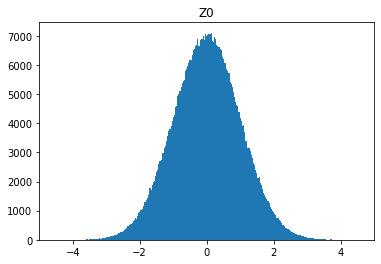

In [18]:
_ = plt.hist(z0, bins='auto')
plt.xlim(-5, 5)
plt.title("Z0")
print("Mean:", z0.mean(), "Std:", z0.std())


Mean: 0.014630554 Std: 1.1216666


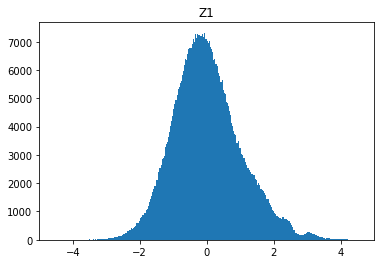

In [10]:
_ = plt.hist(z1, bins='auto')
plt.xlim(-5, 5)
plt.title("Z1")
print("Mean:", z1.mean(), "Std:", z1.std())


## Random sampling and comparing distributions with bkg data

In [11]:
bkg.drop(columns=['name'], inplace=True)

In [12]:
# Sampling from validation
#_ , _, sample, _ = model.test_step(_dataset(category='validation',variant='bkg').all_data())

# Random sample from N(0,1)
sample = np.vstack([model.decode(torch.rand(2)).detach().numpy() for x in range(bkg.shape[0])])

# Make it a dataframe
sample = pd.DataFrame(sample, columns=bkg.columns)


In [13]:
sample.describe()


FatJet_Multi     FatJet1_PT     FatJet2_PT     FatJet3_PT  \
count  370198.000000  370198.000000  370198.000000  370198.000000   
mean        0.118238       0.169586       0.145934      -0.040013   
std         0.077321       0.103914       0.091517       0.044290   
min        -0.004915      -0.007829      -0.007586      -0.150955   
25%         0.058317       0.104542       0.082657      -0.069912   
50%         0.117831       0.175303       0.149716      -0.011431   
75%         0.180734       0.251384       0.227503      -0.007769   
max         0.259232       0.352528       0.294584      -0.004065   

          FatJet4_PT     FatJet5_PT   FatJet1_Mass   FatJet2_Mass  \
count  370198.000000  370198.000000  370198.000000  370198.000000   
mean       -0.083518      -0.014307       0.152323       0.110193   
std         0.002302       0.001091       0.159255       0.102600   
min        -0.088233      -0.016813      -0.043470      -0.018512   
25%        -0.085603      -0.015174      -0.013926      -0.003975   
50%        -0.082501      -0.014472       0.186353       0.141242   
75%        -0.081685      -0.013407       0.292693       0.196862   
max        -0.080090      -0.012101       0.434248       0.283072   

        FatJet3_Mass   FatJet4_Mass  ...  Electron_Multi   Electron1_PT  \
count  370198.000000  370198.000000  ...   370198.000000  370198.000000   
mean       -0.038935      -0.069729  ...       -0.014701      -0.002868   
std         0.041378       0.003425  ...        0.004510       0.001114   
min        -0.141776      -0.077451  ...       -0.022391      -0.004009   
25%        -0.067199      -0.072525  ...       -0.018572      -0.003736   
50%        -0.012467      -0.068040  ...       -0.015484      -0.003492   
75%        -0.008786      -0.067054  ...       -0.010386      -0.001676   
max        -0.004315      -0.065367  ...       -0.007148      -0.000969   

        Electron2_PT  Electron1_Eta  Electron2_Eta  Electron1_Phi  \
count  370198.000000  370198.000000  370198.000000  370198.000000   
mean       -0.001134      -0.002600      -0.002241      -0.003989   
std         0.000267       0.000339       0.000227       0.000400   
min        -0.001568      -0.003045      -0.003126      -0.004575   
25%        -0.001352      -0.002879      -0.002347      -0.004287   
50%        -0.001208      -0.002720      -0.002206      -0.004119   
75%        -0.000899      -0.002271      -0.002097      -0.003841   
max        -0.000584      -0.001915      -0.001764      -0.003105   

       Electron2_Phi  MissingET_MET  MissingET_Phi    ScalarHT_HT  
count  370198.000000  370198.000000  370198.000000  370198.000000  
mean       -0.001124      -0.007113      -0.003332       0.063218  
std         0.000623       0.007205       0.000515       0.138105  
min        -0.002086      -0.025942      -0.004317      -0.145380  
25%        -0.001820      -0.011553      -0.003968      -0.057892  
50%        -0.000965      -0.002718      -0.003070       0.047209  
75%        -0.000567      -0.001987      -0.002930       0.185255  
max        -0.000203      -0.000823      -0.002750       0.337391  

[8 rows x 69 columns]

In [14]:
def plot_graphs2(background, signal, bins=50, num_cols=4):

    # Ignoring irrelevant features such as 'name' and 'weights' in
    # the plotting of the data
    features  = list(background.columns)
    for x in ['name', 'weights']: 
        try:
            features.remove(x)
        except:
            pass

    # Plot creation
    num_rows = int(np.ceil((len(list(signal.columns)) - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(signal[x].min(), background[x].min())
        hist_max = max(signal[x].max(), background[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(background[x], bins=bins, alpha=0.5, label='Real', range=hist_range)
        ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label='Sampled',  range=hist_range)
        
        ax[row, col].autoscale(enable=True) 
        ax[row, col].legend()
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    

Processing...:   0%|          | 0/69 [00:00<?, ?it/s]

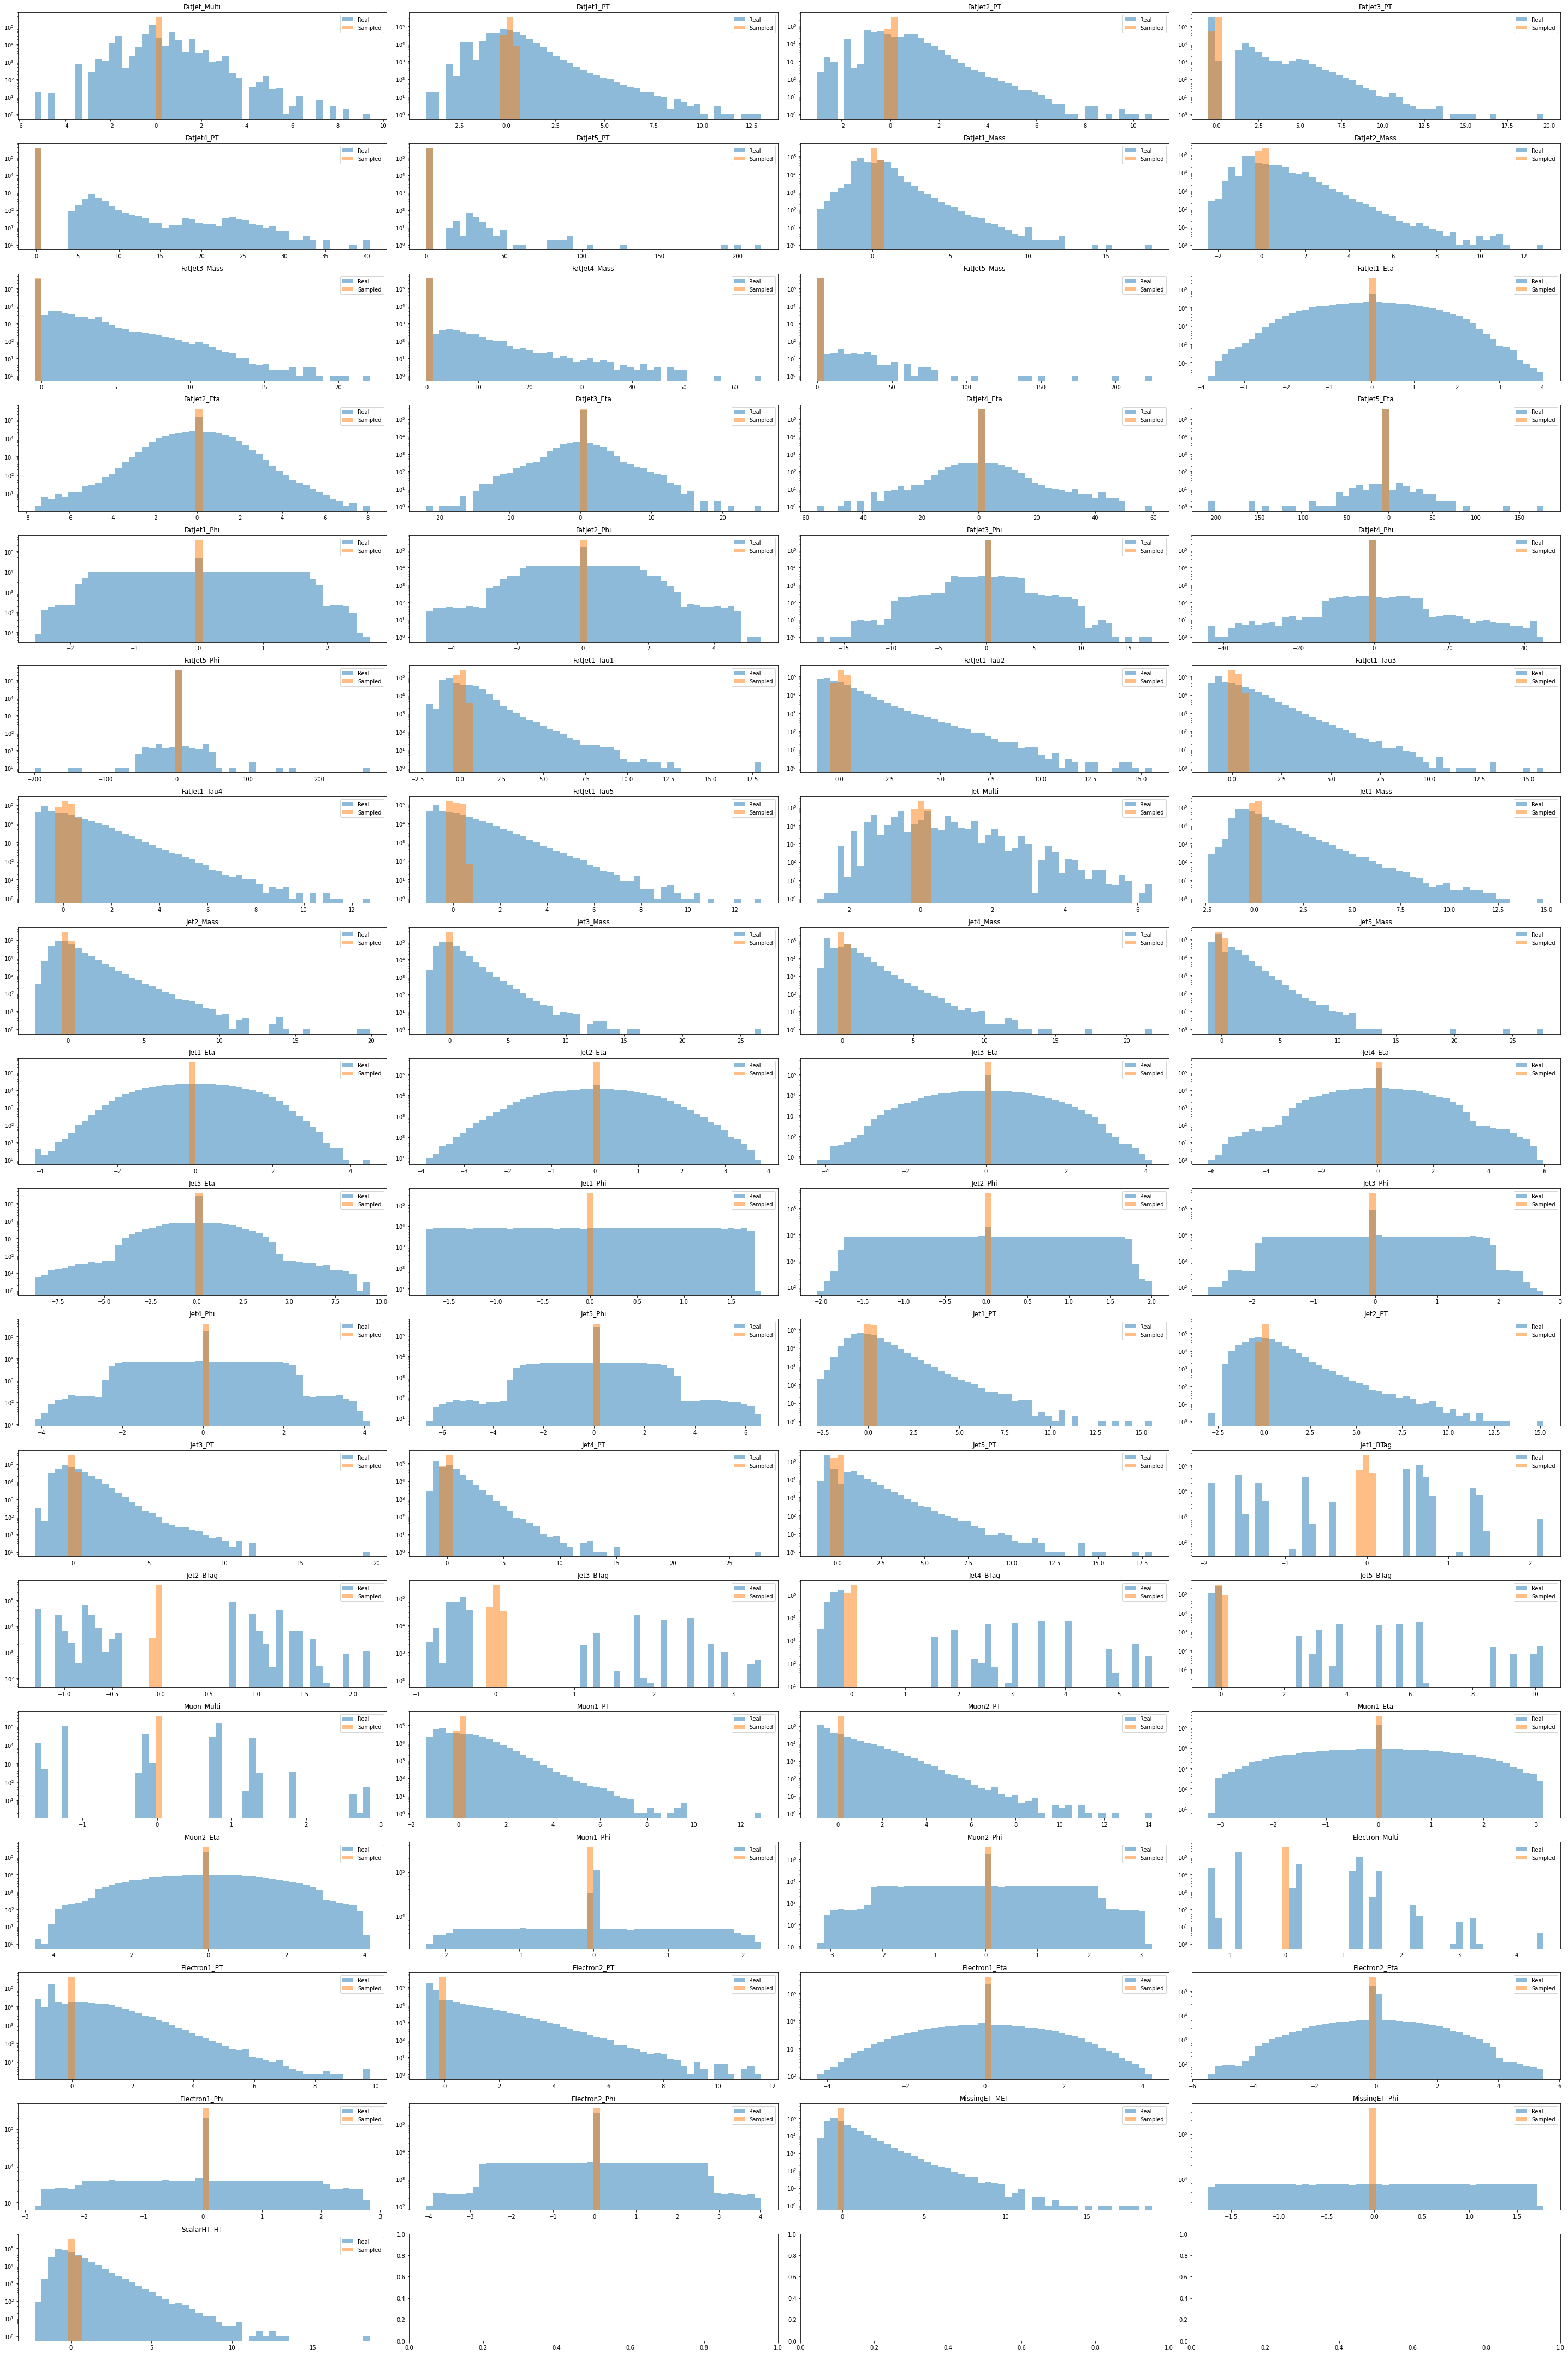

In [16]:
plot_graphs2(bkg, sample)

Plot

  0%|          | 0/6 [00:00<?, ?it/s]

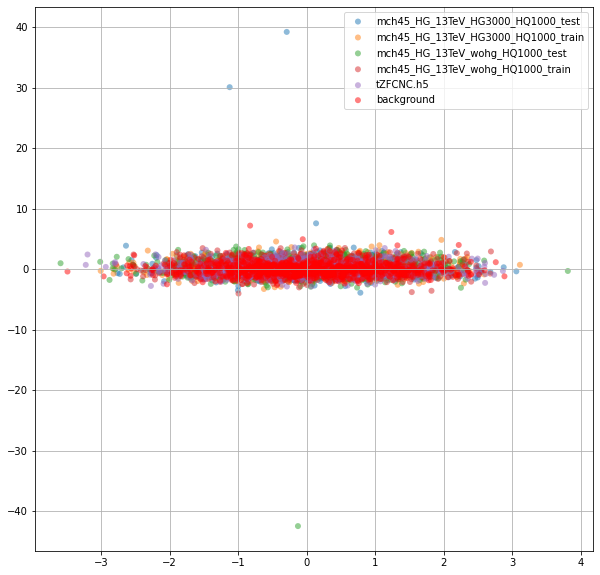

In [17]:
fig, ax = plt.subplots( figsize=(10,10))
for x in tqdm(data['name'].unique()):
    mu, log_var, x_out, hidden = model.test_step(torch.from_numpy(data.loc[data['name'] == x].drop(columns=['name']).to_numpy(dtype=np.float32)))
    hidden = hidden.detach().numpy()

    if x != 'background.csv':
        color = None
    else:
        color = 'r'

    ax.scatter(hidden[:1000, 0], hidden[:1000, 1], label=x.replace('.csv', ''), alpha=0.5, edgecolors='none', c = color)

ax.legend()
ax.grid(True)

plt.show()
